In [36]:
#Separate notebook to work on Topic Modelling with LDA
%pylab inline
from sys import platform
from pprint import pprint
import pandas as pd
from tqdm import trange

if platform == "win32":
    path = 'C:/Users/olive/'
elif platform == "darwin":
    path = '~/'

Populating the interactive namespace from numpy and matplotlib


/Users/ollyjc/Documents/GitHub/COVID-19-Sentiment-and-Compliance-Analyzer/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
c_df = pd.read_pickle(path + 'OneDrive - Cardiff University/Individual Project/processed data/comments.csv')
s_df = pd.read_pickle(path + 'OneDrive - Cardiff University/Individual Project/processed data/submissions.csv')

s_df = s_df.sort_values(by='datetime')
c_df = c_df.sort_values(by='datetime')

In [4]:
comments = c_df.reset_index().drop(columns=['id', 'datetime', 'sentiment', 'compound_score', 'submission_id', 'parent_id'], axis=1)

comments = comments.sample(100)

comments.head()

,body,processed_text
119042,So where do you think this money comes from? ...,so where do you think this money comes from l...
383808,I haven’t got children but we usually get load...,i haven’t got children but we usually get load...
260507,The next concern will be how long they will ke...,the next concern will be how long they will ke...
193741,Fuck the tories. But seriously they’ve been de...,fuck the tories but seriously they’ve been des...
459232,"In my local school, students and teachers have...",in my local school students and teachers have ...


In [5]:
# REMOVE EMAILS AND NEWLINE CHARACTERS

data = comments['processed_text'].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['so where do you think this money comes from labour sold off uk stock of gold '
 'at a really low rate to help with their over funding when the assets are '
 'gone where do you expect the influx of money to come from\\n\\nplease give '
 'an example of the nhs being "sold off" ive heard this mantra and yet nobody '
 'seems to be able to point to exact facts except for pfi by conservatives '
 'well fyi the nhs (private finance) act >1997< was heavily pushed by new '
 'labour who were in power from 1997 till 2010']


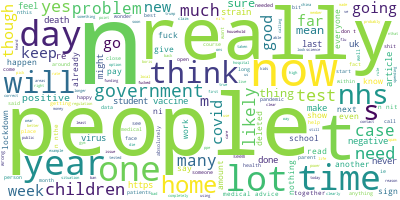

In [6]:
# EXPLORATORY ANALYSIS

from wordcloud import WordCloud

long_string = ','.join(list(comments['processed_text'].values))

wordcloud = WordCloud(background_color="white",
                      max_words=5000,
                      contour_width=3,
                      contour_color='steelblue'
                     )

wordcloud.generate(long_string)

wordcloud.to_image()

In [7]:
# Tokenize words and more text clean-up

import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence),
                                            deacc=True))
        
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

['so', 'where', 'do', 'you', 'think', 'this', 'money', 'comes', 'from', 'labour', 'sold', 'off', 'uk', 'stock', 'of', 'gold', 'at', 'really', 'low', 'rate', 'to', 'help', 'with', 'their', 'over', 'funding', 'when', 'the', 'assets', 'are']


In [8]:
#Bigram and Trigram Phrase Modelling

bigram = gensim.models.Phrases(data_words, 
                               min_count=5, 
                               threshold=100
                              )
trigram = gensim.models.Phrases(bigram[data_words], 
                                threshold=100
                               )

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

print(trigram_mod[bigram_mod[data_words[0]]])

['so', 'where', 'do', 'you', 'think', 'this', 'money', 'comes', 'from', 'labour', 'sold', 'off', 'uk', 'stock', 'of', 'gold', 'at', 'really', 'low', 'rate', 'to', 'help', 'with', 'their', 'over', 'funding', 'when', 'the', 'assets', 'are', 'gone', 'where', 'do', 'you', 'expect', 'the', 'influx', 'of', 'money', 'to', 'come', 'from', 'nplease', 'give', 'an', 'example', 'of', 'the', 'nhs', 'being', 'sold', 'off', 'ive', 'heard', 'this', 'mantra', 'and', 'yet', 'nobody', 'seems', 'to', 'be', 'able', 'to', 'point', 'to', 'exact', 'facts', 'except', 'for', 'pfi', 'by', 'conservatives', 'well', 'fyi', 'the', 'nhs', 'private', 'finance', 'act', 'was', 'heavily', 'pushed', 'by', 'new', 'labour', 'who', 'were', 'in', 'power', 'from', 'till']


In [9]:
#Remove Stopwords, Make Bigrams and Lemmantize

import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from',
                   'subject', 
                   're', 
                   'edu', 
                   'use'])

In [10]:
#Define functions for stopwords, bigrams, trigrams and lemmatization

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
import spacy

data_words_nostops = remove_stopwords(data_words)

data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load("en_core_web_sm", disable=['parser',
                                            'ner'])

data_lemmatized = lemmatization(data_words_bigrams)

print(data_lemmatized[:1])

[['think', 'money', 'come', 'labour', 'sell', 'uk', 'stock', 'gold', 'really', 'low', 'rate', 'help', 'funding', 'asset', 'go', 'expect', 'influx', 'money', 'come', 'nplease', 'give', 'example', 'nhs', 'sell', 've', 'hear', 'mantra', 'yet', 'seem', 'able', 'point', 'exact', 'fact', 'pfi', 'conservative', 'well', 'nhs', 'private', 'finance', 'act', 'heavily', 'push', 'new', 'labour', 'power']]


In [12]:
#Data Tranformation: Corpus and Dictionary

import gensim.corpora as corpora

id2word = corpora.Dictionary(data_lemmatized)
# id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
# texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 2), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 2), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1)]]
[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 2), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 2), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1)]]


In [29]:
# Building LDA model

def build_lda(num_topics):
    return gensim.models.LdaModel(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=num_topics,
                                  random_state=100,
                                  update_every=1,
                                  chunksize=100,
                                  passes=10,
                                  alpha='auto',
                                  per_word_topics=True)

# lda_model = gensim.models.LdaMulticore(corpus=corpus,
#                                        id2word=id2word,
#                                        num_topics=10,
#                                        random_state=100,
#                                        chunksize=100,
#                                        passes=10,
#                                        alpha='auto',
#                                        per_word_topics=True)

/Users/ollyjc/Documents/GitHub/COVID-19-Sentiment-and-Compliance-Analyzer/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
from pprint import pprint

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.014*"get" + 0.014*"really" + 0.014*"call" + 0.011*"people" + 0.011*"day" '
  '+ 0.011*"think" + 0.011*"feel" + 0.009*"go" + 0.009*"student" + '
  '0.009*"time"'),
 (1,
  '0.022*"test" + 0.012*"people" + 0.012*"strain" + 0.012*"negative" + '
  '0.010*"s" + 0.010*"good" + 0.010*"virus" + 0.007*"death" + 0.007*"go" + '
  '0.007*"do"'),
 (2,
  '0.016*"nhs" + 0.012*"point" + 0.012*"boris" + 0.012*"https" + 0.008*"uk" + '
  '0.008*"funding" + 0.008*"go" + 0.008*"sure" + 0.008*"money" + '
  '0.008*"patient"'),
 (3,
  '0.020*"do" + 0.014*"delete" + 0.012*"s" + 0.012*"people" + 0.012*"happen" + '
  '0.012*"lockdown" + 0.009*"government" + 0.009*"vaccine" + 0.009*"sure" + '
  '0.009*"say"'),
 (4,
  '0.014*"s" + 0.012*"re" + 0.009*"much" + 0.009*"time" + 0.009*"make" + '
  '0.009*"need" + 0.009*"week" + 0.007*"lot" + 0.007*"go" + 0.007*"take"'),
 (5,
  '0.017*"medical" + 0.017*"child" + 0.015*"really" + 0.014*"advice" + '
  '0.012*"get" + 0.010*"do" + 0.010*"give" + 0.010*"people" + 0.0

/Users/ollyjc/Documents/GitHub/COVID-19-Sentiment-and-Compliance-Analyzer/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/ollyjc/Documents/GitHub/COVID-19-Sentiment-and-Compliance-Analyzer/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


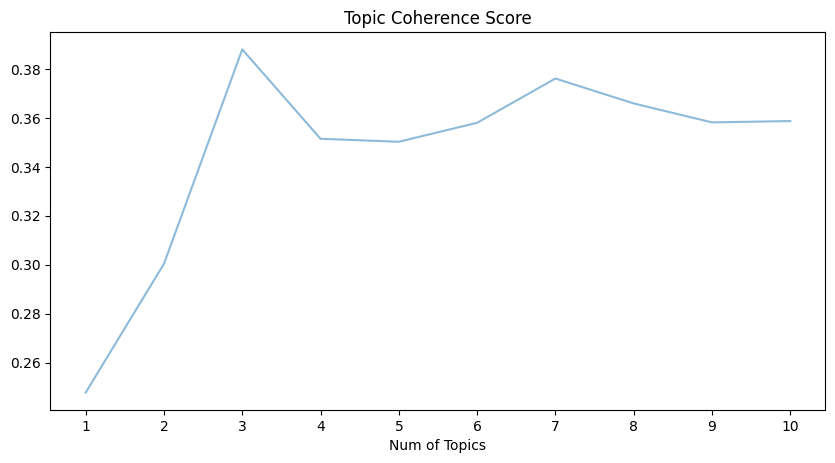

In [49]:
# METHOD FOR TESTING COHERENCE SCORE FOR DIFFERING NUMBERS OF TOPICS

from gensim.models import CoherenceModel

topic_coherence = []
num_topics = 10

for n in trange(1, num_topics + 1):
    
    lda_model = build_lda(n)
    
    # Compute Perplexity
    topic_perplexity = lda_model.log_perplexity(corpus)

    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, 
                                         texts=data_lemmatized, 
                                         dictionary=id2word, 
                                         coherence='c_v')
    
    topic_coherence.append(coherence_model_lda.get_coherence())


x = [i for i in range(1, num_topics + 1)]

fig, ax1 = plt.subplots(1, dpi=100)
fig.set_size_inches(10, 5)

ax1.set_title('Topic Coherence Score')
ax1.set_xlabel('Num of Topics')
ax1.set_ylabel('Coherence Score')
ax1.set_xticks(x)
ax1.plot(x, topic_coherence, alpha=0.5)

In [ ]:
# Hyperparameter Tuning
def compute_coherence_values(corpus, dictionary, k, a, b):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, 
                                         texts=data_lemmatized, 
                                         dictionary=id2word,
                                         coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [25]:
import pyLDAvis.gensim_models
import os
import pickle
import pyLDAvis

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model,
                                     corpus,
                                     id2word)
vis

/Users/ollyjc/Documents/GitHub/COVID-19-Sentiment-and-Compliance-Analyzer/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.159463 -0.053267       1        1  16.723462
5     -0.047616  0.113912       2        1  15.682033
1      0.060391 -0.052733       3        1  15.514666
0      0.036964 -0.052834       4        1  12.616707
3      0.050923  0.108012       5        1  12.067027
6      0.069976 -0.026311       6        1  11.930717
7     -0.024812  0.028352       7        1   8.183846
2      0.013637 -0.065131       8        1   7.281542, topic_info=         Term      Freq      Total Category  logprob  loglift
158      test  8.000000   8.000000  Default  30.0000  30.0000
894   medical  7.000000   7.000000  Default  29.0000  29.0000
40      child  6.000000   6.000000  Default  28.0000  28.0000
23        nhs  5.000000   5.000000  Default  27.0000  27.0000
387    delete  3.000000   3.000000  Default  26.0000  26.0000
..        ...       ...        ...      ...      ...      ...
64     people  0.605396  16.211445   Topic8  -5.4442  -0.6678
111      vote  0.605214   1.905156   Topic8  -5.4445   1.4731
674  hospital  0.605214   2.522443   Topic8  -5.4445   1.1924
624      feel  0.605214   5.928670   Topic8  -5.4445   0.3379
481  together  0.605214   3.712363   Topic8  -5.4445   0.8060

[484 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
619       4  0.503929    absolute
388       1  0.591500  absolutely
388       3  0.295750  absolutely
388       7  0.295750  absolutely
91        2  0.708340      advice
...     ...       ...         ...
76        5  0.125172        year
76        6  0.125172        year
76        7  0.125172        year
160       4  0.758214   yesterday
322       5  0.764039     zealand

[702 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 2, 1, 4, 7, 8, 3])

In [ ]:
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, num_of_docs*0.75), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

#Can take a while to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], 
                                                  dictionary=id2word, 
                                                  k=k, 
                                                  a=a,
                                                  b=b)
                    print('Alert')
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
                    
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv',
                                       index=False)
    pbar.close()
